<br>
<h1 align="center"><font size="7" face="arial" color="#DC5A29">Modelling Stroke</font></h1>
<h1 align="center"><font size="7" face="arial" color="#DC5A29">using TVB</font></h1>
<br>
<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">John Griffiths</font></span></h3>
<h3 align="center"><span style="font-weight:normal"><font size="5" face="arial">Ana Solodkin</font></span></h3>

---

<h1><font size="6" face="arial" color="#609BC4">Contents</font></h1>

<p><div style="text-align: justify"><font size="4.5" face="time roman">

[Summary](#Summary)    
[Setup](#Setup)   
[Creating 'lesioned' connectivity matrices](#Creating-'lesioned'-connectivity-matrices)  
[Define simulation functions](#Define-simulation-functions)  
[Effects of lesions on brain dynamics 1: PSEs](#Effects-of-lesions-on-brain-dynamics-1:-PSEs)  
[Effects of lesions on brain dynamics 2: Functional connectivity](#Effects-of-lesions-on-brain-dynamics-2:-Functional-connectivity)  
[Conclusions](#Conclusions)  
[References](#References)  

</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Summary</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">


In this tutorial we shall be modelling the effects of middle cerebrel artery infarct (MCAI) stroke using TVB. The are two main components to the following demonstrations: 1) defining a lesion by modifying anatomical connectivity matrices, and 2) simulating neural activity with and without lesions, and comparing the two. We shall use some relatively compact parameter space explorations (PSEs) to see how estimates of global coupling and conduction velocity change following damage; shall also look at how the models predict changes in functional connectivity between regions not directly affected by the damage.


</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Setup</font></h1>
***


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 


*Install non-default libraries* 

<br> <br>


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 


In this tutorial we shall be making use of two very widely used python libraries are not currently TVB dependencies: [nilearn](https://nilearn.github.io/) and [seaborn](https://nilearn.github.io/). This means you will have to install them yourselves; which is a good idea anyway because they're very handy.  

<br> <br>

If you are using a standard python installation, you can simply do   

<br> <br>


`pip install seaborn nilearn`  


<br> <br>

from the command line.  


<br> <br>

Alternatively, you can do this directly in python in a jupyter notebook like so: 

<br> <br>

`import pip`

<br>

`pip.main(['install', 'nilearn'])` 

<br>

`pip.main(['install', 'seaborn'])`

<br> <br>

If you are running this notebook in the TVB distribution python environment, you will want to do the latter. Either start a new notebook and copy-paste the above, or just uncomment and execute the cell below. 

</font></div></p>

In [3]:
#import pip 
#pip.main(['install', 'nilearn'])
#pip.main(['install', 'seaborn'])

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

*Importage* 

</font></div></p>

In [1]:

# Generic stuff

import itertools,pandas as pd,numpy as np,nibabel as nib
from copy import deepcopy
from __future__ import print_function # this ensures the code will still work when TVB is upgraded to python 3
import warnings                       # this helps with aesthetics; but should only be used when you have 
warnings.filterwarnings('ignore')     # verified everything works


# TVB stuff

from tvb.simulator.lab import *


# Visualization stuff

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize, ListedColormap
from mpl_toolkits import mplot3d
import seaborn as sns; sns.set_style('white')
from nilearn.plotting import plot_surf_stat_map,plot_surf_roi,plot_connectome


   INFO  log level set to INFO


<h1><font size="6" face="arial" color="#609BC4">Creating 'lesioned' connectivity matrices</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***Summary of approach*** 

</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

The approach we take here to studying the effects of regional grey and/or white matter damage is to *modify the weights of connectivity matrices* derived from otherwise 'healthy' (control) subjects.

<br><br>

This strategy may also be used in modelling other neurological conditions such as neurodegeneration or traumatic injury; although sufficient background knowledge of the relevant anatomy and physiology is always absolutely essential. 

<br><br>

In this example we focus on a 'canonical' middle cerebral artery infarct (MCAI); which is a very common type of stroke that primarily affects temporal, frontal, and parietal brain regions. For present purposes we shall be describing the typical pattern of grey matter damage resulting from an MCAI in a binary fashion, with a '1' indicating a region is damaged, and a '0' indicating that it is unaffected. Regions lablled '1' are considered to be comprehensively damaged and no longer present (e.g. appearing as 'black zones' on T1-weighted MRI). 

<br><br>

(Note that for the sake of expedience we are not considering the slightly more complicated issue of white matter damage in this tutorial; appropriate modifications to deal with this should be fairly self-evident).

<br><br>


~~~

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Practically speaking, there are two options for representing this pattern of grey matter damage in network simulations such as those we do with TVB. 

<br><br>

The first is to remove the damaged regions from the connectivity completely; i.e. to create a new 'lesioned' connectivity with $N-M$ nodes, where $N$ is the original number of grey matter regions, and $M$ is the number of damaged regions. 

<br><br>

The second option, which we take in this tutorial, is to retain the damaged regions in the connectivity matrix, but completely sever them from the rest of the brain - i.e. set all connection strengths to and from those regions to zero. This has a number of practical advantages over the first option, most of which relate to the fact that (as we shall see) we can use the same lists, indices, numberings in analysis and plotting commands for both the lesioned and non-lesioned connectivity.

<br><br>

The one downside to this is the potential for confusion, due to the fact that the lesioned nodes are still present in the lesioned connectivities and simulations we run with them., It is critical to remember that for correct interpretations, ***these nodes should be ignored.*** What exactly is meant by this shall become clear as we proceed. 

</font></div></p>


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

***Load connectivity*** 

</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

A key feature of the connectome-based brain network modelling approach exemplified by TVB is the ability (given the requisite data) to construct personalized models of individual subjects' and/or patients' brains.

<br><br>

In this tutorial we shall be conducting simulations using anatomical connectivity data from 5 healthy subjects. 

</font></div></p>

In [2]:
## 1. Define the filepaths for the connectivity zip folders. 

# 'abspath' here makes sure the full (as opposed to relative) file path is given; 
# if a full path is not given, TVB will expect look in the default data folder

s1_file = os.path.abspath('s1.zip')
s2_file = os.path.abspath('s2.zip')
s3_file = os.path.abspath('s3.zip')
s4_file = os.path.abspath('s4.zip')                                                
s5_file = os.path.abspath('s5.zip')

# each of these zip files is contains the standard minimal contents for 
# a TVB connectivity: 
# - weights.txt             connectivity (edge) weights
# - tract_lengths.txt       connectivity (edge) lengths
# - centres.txt             region (node) labels, AND
#                           XYZ coordinates of region centres 


## 2. Load the data

s1_conn = connectivity.Connectivity.from_file(s1_file)
s2_conn = connectivity.Connectivity.from_file(s2_file)
s3_conn = connectivity.Connectivity.from_file(s3_file)
s4_conn = connectivity.Connectivity.from_file(s4_file)
s5_conn = connectivity.Connectivity.from_file(s5_file)


# 3. Collect into a dictionary for convenience

ctrl_conns = {'s1': s1_conn, 's2': s2_conn, 's3': s3_conn, 's4': s4_conn, 's5': s5_conn}

for conn_name,conn in ctrl_conns.items(): conn.configure() # this completes the initialization of the new connectivities


# 4. Collect into a pandas dataframe for convience

df_ctrl_conns = pd.concat({k: pd.DataFrame(v.weights) for k,v in ctrl_conns.items()})
df_ctrl_conns.index.names = ['sub', 'row']
df_ctrl_conns.columns.names = ['col']


# 5. Calculate similarity between each connectivity

# This is the pearson correlation between each of the 5 connectivities
df_ctrl_conns_pcmat = df_ctrl_conns.unstack('row').T.corr()


WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

The essential first step in any type of data anlysis is always to *look at the data*. TVB simulations are not different. 

<br><br>

First let's take a quick look at the cortical parcellation we are using.

<br><br>

This information is contained in the `connectivity` object. 
</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> We have 82 regions </font></div></p>

In [3]:
s1_conn.number_of_regions

82L

In [4]:
s1_conn.region_labels

array(['ctx-lh-lateralorbitofrontal', 'ctx-lh-parsorbitalis',
       'ctx-lh-frontalpole', 'ctx-lh-medialorbitofrontal',
       'ctx-lh-parstriangularis', 'ctx-lh-parsopercularis',
       'ctx-lh-rostralmiddlefrontal', 'ctx-lh-superiorfrontal',
       'ctx-lh-caudalmiddlefrontal', 'ctx-lh-precentral',
       'ctx-lh-paracentral', 'ctx-lh-rostralanteriorcingulate',
       'ctx-lh-caudalanteriorcingulate', 'ctx-lh-posteriorcingulate',
       'ctx-lh-isthmuscingulate', 'ctx-lh-postcentral',
       'ctx-lh-supramarginal', 'ctx-lh-superiorparietal',
       'ctx-lh-inferiorparietal', 'ctx-lh-precuneus', 'ctx-lh-cuneus',
       'ctx-lh-pericalcarine', 'ctx-lh-lateraloccipital', 'ctx-lh-lingual',
       'ctx-lh-fusiform', 'ctx-lh-parahippocampal', 'ctx-lh-entorhinal',
       'ctx-lh-temporalpole', 'ctx-lh-inferiortemporal',
       'ctx-lh-middletemporal', 'ctx-lh-bankssts',
       'ctx-lh-superiortemporal', 'ctx-lh-transversetemporal',
       'ctx-lh-insula', 'Left-Thalamus-Proper', 'Left-Caud

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

...of which 68 are cortical, and 14 are subcortical 

</font></div></p>


In [5]:
s1_conn.cortical

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True, False, False, False, False, False, False, False], dtype=bool)

In [6]:
print('number of cortical regions: %s' % np.nonzero(s1_conn.cortical == 1)[0].shape)
print('number of subcortical regions: %s' % np.nonzero(s1_conn.cortical == 0)[0].shape)

number of cortical regions: 68
number of subcortical regions: 14


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

...and is symmetric; 41 in the left, 41 in the right

</font></div></p>


In [7]:
s1_conn.hemispheres

array([False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,  True], dtype=bool)

In [8]:
print('number of left hemisphere: %s' % np.nonzero(s1_conn.hemispheres == 0)[0].shape)
print('number of right hemisphere: %s' % np.nonzero(s1_conn.hemispheres == 1)[0].shape)

number of left hemisphere: 41
number of right hemisphere: 41


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

We also have an associated cortical surface (adapted from freesurfer's fsaverage5) and region mapping (i.e. freesurfer 'labels'); which in this case we will only be using for visualization purposes. 

</font></div></p>


In [9]:
vtx,tri = nib.freesurfer.read_geometry('bihemi.pial')
regmap = np.loadtxt('regmap.txt').astype(int)

In [10]:
vtx.shape

(20484L, 3L)

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Because the surface is not too dense (~20000 vertices), it works nicely as a scatter plot, and allows us to give some visual context for the locations of the region centres. 

<br> <br>

(note, if doing this for denser cortical surface meshes, you will want to choose a subset of vertices to plot) 

</font></div></p>


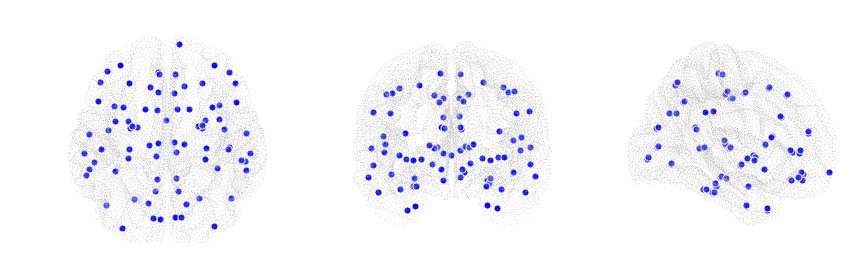

In [11]:
df_roi_xyz = pd.DataFrame(s1_conn.centres, columns=['x', 'y', 'z'])
df_vtx_xyz = pd.DataFrame(vtx, columns=['x', 'y', 'z'])


fig, ax = plt.subplots(ncols=3, figsize=(12,4))

df_roi_xyz.plot(kind='scatter', x='x', y='y',ax=ax[0],c='b',s=50)#,alpha=0.5)
df_roi_xyz.plot(kind='scatter', x='x', y='z',ax=ax[1],c='b',s=50)#,alpha=0.5)
df_roi_xyz.plot(kind='scatter', x='y', y='z',ax=ax[2],c='b',s=50)#,alpha=0.5)

df_vtx_xyz.plot(kind='scatter', x='x', y='y', ax=ax[0],s=1, alpha=0.1, c='k')
df_vtx_xyz.plot(kind='scatter', x='x', y='z', ax=ax[1],s=1, alpha=0.1, c='k')
df_vtx_xyz.plot(kind='scatter', x='y', y='z', ax=ax[2],s=1, alpha=0.1, c='k')
    
ax[0].set_ylim([-100,90])
ax[1].set_xlim([-80,80])
ax[2].set_xlim([-110,80])

for a in ax.ravel(): a.axis('off')
    
plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
We can also view these as parcels on the cortical surface

</font></div></p>

In [12]:
np.unique(regmap)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34,
       35, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,
       58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74,
       75, 76])

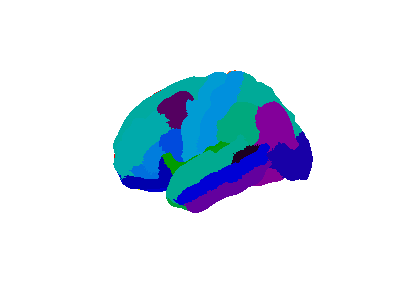

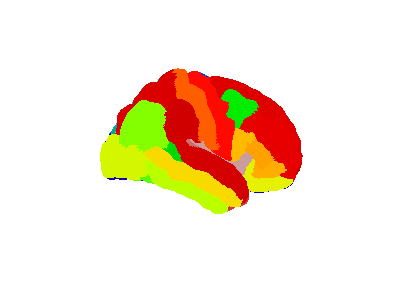

In [13]:
_ = plot_surf_roi([vtx,tri],regmap, hemi='left', view='lateral',cmap='spectral')
_ = plot_surf_roi([vtx,tri],regmap, hemi='right', view='lateral',cmap='spectral')

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Now let's look at our 5 subject's anatomical connectivity matrices, which are the central component of individualized TVB simulations. 

</font></div></p>

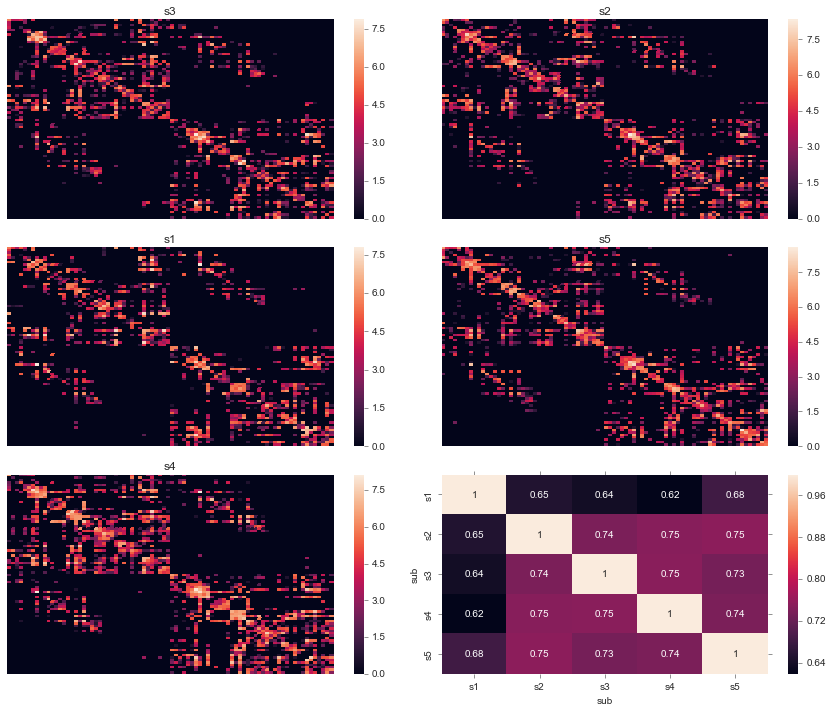

In [14]:
fig, ax = plt.subplots(ncols=2, nrows=3,figsize=(12,10))

for (kv_it,(k,v)) in enumerate(ctrl_conns.items()):

    thisax = ax.ravel()[kv_it]
    sns.heatmap(v.weights,ax=thisax,xticklabels='',yticklabels='')
    thisax.set_title(k)
    
thisax = ax.ravel()[-1]
sns.heatmap(df_ctrl_conns_pcmat,ax=thisax,annot=True)

plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

There are a number of familiar and important features of these connectivity matrices that can be discerned from these figures. 


<br>
<br>

*Node ordering*

In order to properly examine connectivity matrices, you need to know the node ordering; i.e. (broadly speaking) which brain regions the rows and columns correspond to. The most common and most useful ordering scheme is to split into left and right hemisphere blocks, and then within those blocks split into cortical/subcortical, and finally within the cortical block order the nodes approximately distance from back to front ( = along the MNI space Y-axis). This is the ordering scheme used here. 
( The additional information in the TVB connectivity object is helpful here; c.f. the `.region_labels`, `.hemispheres`, and  `.cortical` attributes ) . 

<br>
<br>

*Main diagonal*

Connectivity in the human brain, and indeed pretty much all complex nervous systems, has a strong distance-dependence; i.e. nearby areas tend to be more highly connected. This feature can be seen in the connectivity matrices as the dense band around the main diagonal. Because our intra-hemispheric cortical block is ordered by distance, brain regions that are near to each other will be situated at nearby rows/columns, and the connections between nearby regions will sit near the diagonal. 

<br>
<br>

*Cross-hemispheric connections*

The due to the highest level left/right block ordering, and the fact that the sub-ordering within each left/right block is identical, the entries in the top right and bottom left blocks have the same layout as in the top left and bottom right blocks, except that they represent cross-hemipheric, rather than intra-hemispheric connections. The secondary diagonals (diagonals within the top right and bottom left blocks) therefore represent cross-hemispheric connections between homologous regions. Due to the distance relationships described above, the entries near the secondary diagonals represent cross-hemispheric connections between near-homologous regions (i.e. to neighbours of homologues). Again, in pretty much all complex nervous systems, cross-hemispheric connections are invariably weaker than intra-hemispheric connections; and this is manifestly the case for the human brain. Connections between hemispheric homologues and their neighbours are always the strongest cross-hemispheric connections, hence the typical 'banded secondary diagonal' appearance of these connectiivties. 

</font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> ***Create lesioned connectivities*** </font></div></p>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Now we shall introduce 'artifical' lesions into our 5 healthy anatomical connectomes. 

<br> <br>

First let's take a look at the parcellation regions on the cortical surface

<br> <br>


We start with a list indicating the indices of which regions are affected by a 'canonical', left-hemisphere MCAI stroke. 

</font></div></p>

In [15]:
lhmca_idxs = np.array([1, 4, 5, 6, 7, 8, 9, 15, 16, 17, 18, 22, 28, 29, 30, 31, 32, 33])

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The region labels for these are as follows:

</font></div></p>

In [16]:
s1_conn.region_labels[lhmca_idxs]

array(['ctx-lh-parsorbitalis', 'ctx-lh-parstriangularis',
       'ctx-lh-parsopercularis', 'ctx-lh-rostralmiddlefrontal',
       'ctx-lh-superiorfrontal', 'ctx-lh-caudalmiddlefrontal',
       'ctx-lh-precentral', 'ctx-lh-postcentral', 'ctx-lh-supramarginal',
       'ctx-lh-superiorparietal', 'ctx-lh-inferiorparietal',
       'ctx-lh-lateraloccipital', 'ctx-lh-inferiortemporal',
       'ctx-lh-middletemporal', 'ctx-lh-bankssts',
       'ctx-lh-superiortemporal', 'ctx-lh-transversetemporal',
       'ctx-lh-insula'],
      dtype='|S31')

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

We also will be needing a complementary list containing the indices of intact (non-lesioned) regions.

<br> <br>

This is fairly straightforward and intuitive to define in python given the previous list:

</font></div></p>

In [17]:
intact_idxs = np.array([i_it for i_it,i in enumerate(s1_conn.region_labels) if i_it not in lhmca_idxs])
intact_idxs

array([ 0,  2,  3, 10, 11, 12, 13, 14, 19, 20, 21, 23, 24, 25, 26, 27, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81])

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

For completeness, let's list the the region labels for these as well:

</font></div></p>

In [18]:
s1_conn.region_labels[intact_idxs]

array(['ctx-lh-lateralorbitofrontal', 'ctx-lh-frontalpole',
       'ctx-lh-medialorbitofrontal', 'ctx-lh-paracentral',
       'ctx-lh-rostralanteriorcingulate', 'ctx-lh-caudalanteriorcingulate',
       'ctx-lh-posteriorcingulate', 'ctx-lh-isthmuscingulate',
       'ctx-lh-precuneus', 'ctx-lh-cuneus', 'ctx-lh-pericalcarine',
       'ctx-lh-lingual', 'ctx-lh-fusiform', 'ctx-lh-parahippocampal',
       'ctx-lh-entorhinal', 'ctx-lh-temporalpole', 'Left-Thalamus-Proper',
       'Left-Caudate', 'Left-Putamen', 'Left-Pallidum',
       'Left-Accumbens-area', 'Left-Hippocampus', 'Left-Amygdala',
       'ctx-rh-lateralorbitofrontal', 'ctx-rh-parsorbitalis',
       'ctx-rh-frontalpole', 'ctx-rh-medialorbitofrontal',
       'ctx-rh-parstriangularis', 'ctx-rh-parsopercularis',
       'ctx-rh-rostralmiddlefrontal', 'ctx-rh-superiorfrontal',
       'ctx-rh-caudalmiddlefrontal', 'ctx-rh-precentral',
       'ctx-rh-paracentral', 'ctx-rh-rostralanteriorcingulate',
       'ctx-rh-caudalanteriorcingulate'

<p><div style="text-align: justify"><font size="4.5" face="time roman">

In summary: 

<br>
<br>

of the original 82 nodes...</font></div></p>



In [19]:
len(s1_conn.region_labels)

82

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
There are 18 lesioned...

</font></div></p>

In [20]:
len(lhmca_idxs)

18

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
...leaving 64 non-lesioned
</font></div></p>


In [21]:
len(intact_idxs)

64

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
So now let's take another look at our ROIs, picking out the lesioned regions:

</font></div></p>

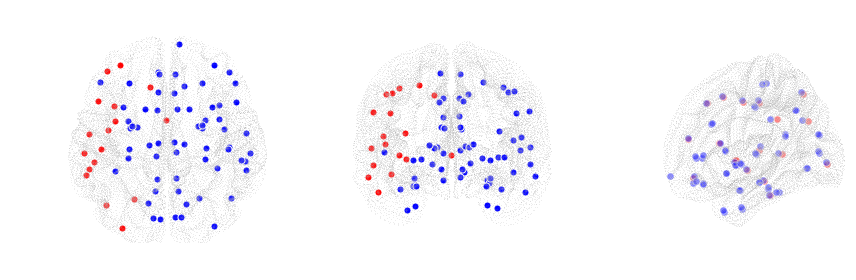

In [22]:
df_roi_xyz = pd.DataFrame(s1_conn.centres, columns=['x', 'y', 'z'])
df_vtx_xyz = pd.DataFrame(vtx, columns=['x', 'y', 'z'])

df_vtx_xyz_refl  = df_vtx_xyz.copy()
df_roi_xyz_refl = df_roi_xyz.copy()
df_vtx_xyz_refl['y'] *=-1
df_roi_xyz_refl['y'] *=-1


fig, ax = plt.subplots(ncols=3, figsize=(12,4))

df_roi_xyz.iloc[lhmca_idxs,:].plot(kind='scatter', x='x', y='y',ax=ax[0],c='r',s=50)#,alpha=0.5)
df_roi_xyz.iloc[intact_idxs,:].plot(kind='scatter', x='x', y='y',ax=ax[0],c='b',s=50)#,alpha=0.5)

df_roi_xyz.iloc[lhmca_idxs,:].plot(kind='scatter', x='x', y='z',ax=ax[1],c='r',s=50)#,alpha=0.5)
df_roi_xyz.iloc[intact_idxs,:].plot(kind='scatter', x='x', y='z',ax=ax[1],c='b',s=50)#,alpha=0.5)

df_roi_xyz_refl.iloc[lhmca_idxs,:].plot(kind='scatter', x='y', y='z',ax=ax[2],c='r',s=50,alpha=0.5)
df_roi_xyz_refl.iloc[intact_idxs,:].plot(kind='scatter', x='y', y='z',ax=ax[2],c='b',s=50,alpha=0.5)

df_vtx_xyz.plot(kind='scatter', x='x', y='y', ax=ax[0],s=1, alpha=0.1, c='k')
df_vtx_xyz.plot(kind='scatter', x='x', y='z', ax=ax[1],s=1, alpha=0.1, c='k')

df_vtx_xyz_refl.plot(kind='scatter', x='y', y='z', ax=ax[2],s=1, alpha=0.1, c='k')


ax[0].set_ylim([-100,90])
ax[1].set_xlim([-80,80])
ax[2].set_xlim([-110,110])
ax[2].set_ylim([-60,110])

for a in ax.ravel(): a.axis('off')
    
plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The red dots here show the centroids of our MCAI lesioned nodes. The blue dots are the centroids of the unaffected nodes. The grey background is the cortical (pial) surface. 

<br> <br>

Now we need to turn these these regional or node-wise lesion assignments into lesioned brain networks. 

</font></div></p>

In [23]:
## 1. Load in the original connectivities

s1_conn_lhmca = connectivity.Connectivity.from_file(s1_file)
s2_conn_lhmca = connectivity.Connectivity.from_file(s2_file)
s3_conn_lhmca = connectivity.Connectivity.from_file(s3_file)
s4_conn_lhmca = connectivity.Connectivity.from_file(s4_file)
s5_conn_lhmca = connectivity.Connectivity.from_file(s5_file)


# 2. Collect into a dictionary for convenience

les_conns  = {'s1_lhmca': s1_conn_lhmca, 's2_lhmca': s2_conn_lhmca, 's3_lhmca': s3_conn_lhmca, 
              's4_lhmca': s4_conn_lhmca, 's5_lhmca': s5_conn_lhmca}

# 3. Apply the lesions

for conn_name,conn in les_conns.items():
    conn.weights[lhmca_idxs,:] = 0 
    conn.weights[:,lhmca_idxs] = 0
    conn.configure() # As above, this completes the initialization of the new connectivities
    

    
# 4. For convenience, make a combined dictionary containing both the original and lesioned connectivities

all_conns = deepcopy(ctrl_conns)
all_conns.update(les_conns)    

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.
WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Now, of course we also want to visualize the outputs of the above operation; so we know that it was done correctly, and also to help with our general intuition of the process. 

<br> <br>


The quickest way to do that is to simply plot the original and lesioned connectivities next to each other:


</font></div></p>

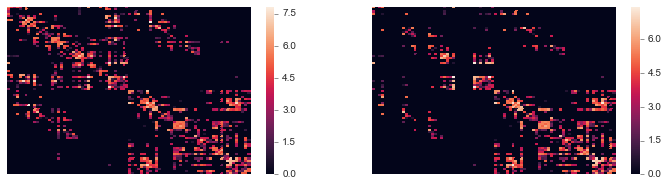

In [24]:
fig, ax = plt.subplots(ncols=2, figsize=(12,3))

sns.heatmap(s1_conn.weights,xticklabels='',yticklabels='',ax=ax[0])
sns.heatmap(s1_conn_lhmca.weights,xticklabels='',yticklabels='',ax=ax[1])

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

You can probably pick out some of the differences there; but they're actually not very easy to see this way because there are already quite a lot of zeros in the original connectivity matrix. So the additional ones we've introduced with the lesion don't stand out much. 

<br> <br>


A better way of visualizing the influence of the lesion on the connectivity is make another lesioned connectivity matrix, but instead of zeros pick a very high number to set the lesioned weights to:


</font></div></p>

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


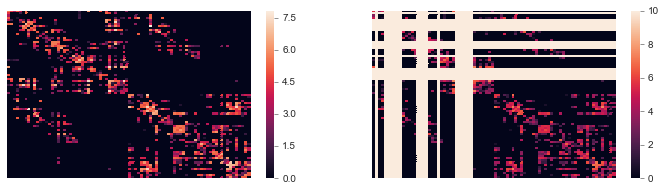

In [25]:
highval = 10.
s1_conn_lhmca_viz = connectivity.Connectivity.from_file(s1_file)
s1_conn_lhmca_viz.weights[lhmca_idxs,:] = highval
s1_conn_lhmca_viz.weights[:,lhmca_idxs] = highval

fig, ax = plt.subplots(ncols=2, figsize=(12,3))
sns.heatmap(s1_conn.weights,xticklabels='',yticklabels='',ax=ax[0])
sns.heatmap(s1_conn_lhmca_viz.weights,xticklabels='',yticklabels='',ax=ax[1])

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Plot the lesioned one a little larger so we can see the region labels alongside

</font></div></p>

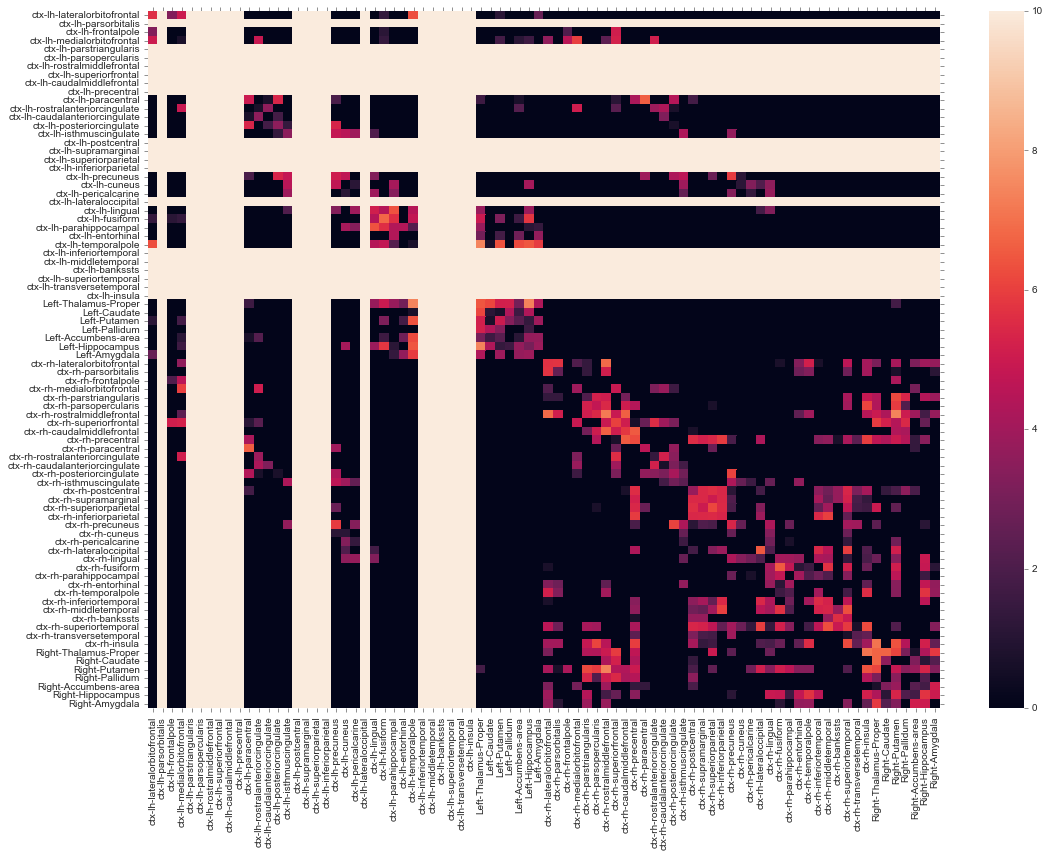

In [26]:
fig, ax = plt.subplots(figsize=(16,12))
sns.heatmap(s1_conn_lhmca_viz.weights,xticklabels=s1_conn.region_labels,yticklabels=s1_conn.region_labels,ax=ax)
plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> So the bands here indicate all of the connectivity matrix entries that we have set to zero to represent disconnections resulting from damaged grey matter. 

<br> <br>

Note of course that not every entry within those bands was necessarily non-zero in the first place (indeed the cross-hemispheric pairs in the upper right and lower left quadrants are mostly zeros); so this representation does exaggerate slightly the extend of the lesion perturbation. 

<br> <br>

Here is a more precise representation, of removed vs. retained connections, plotted on a brain to help with anatomical gist:

</font></div></p>

In [27]:
node_colors = np.zeros(s1_conn.number_of_regions)
node_colors[lhmca_idxs] = 1

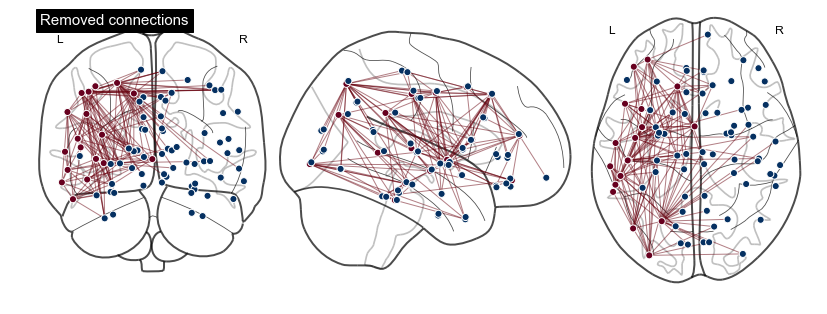

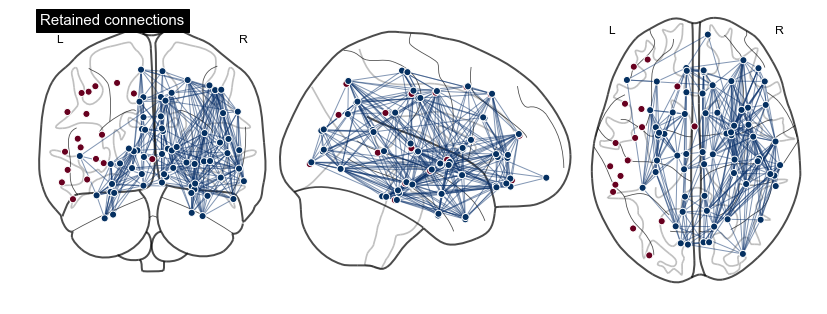

In [28]:
fig, ax = plt.subplots(figsize=(14,5))

tmp = (s1_conn.weights>0).astype(float)
tmp2 = np.zeros_like(s1_conn.weights)
tmp2[lhmca_idxs,:] = 1
tmp2[:,lhmca_idxs] = 1
tmp3 = tmp * tmp2
removed_cnxns = tmp3

fig = plot_connectome(removed_cnxns,df_roi_xyz.values,
                      node_color=node_colors,edge_cmap='Reds',
                      node_kwargs={'cmap': 'RdBu_r'},
                      edge_kwargs={'linewidth': 1.0, 'alpha': 0.5},
                      axes=ax,title = 'Removed connections');


fig, ax  =plt.subplots(figsize=(14,5))

tmp = (s1_conn.weights>0).astype(float)
tmp2 = np.ones_like(s1_conn.weights)
tmp2[lhmca_idxs,:] = 0
tmp2[:,lhmca_idxs] = 0
tmp3 = tmp * tmp2
retained_cnxns = tmp3

fig = plot_connectome(retained_cnxns,df_roi_xyz.values,
                      node_color=node_colors, edge_cmap='Blues',
                      edge_kwargs={'linewidth': 1.0, 'alpha': 0.5},
                      node_kwargs={'cmap': 'RdBu_r'},axes=ax, title='Retained connections')


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Finally, another type of visualization we will be making use of later is to only plot the non-lesioned connectivity matrix entries. 

This is shown below, with the original matrix shown again for comparison. 

</font></div></p>

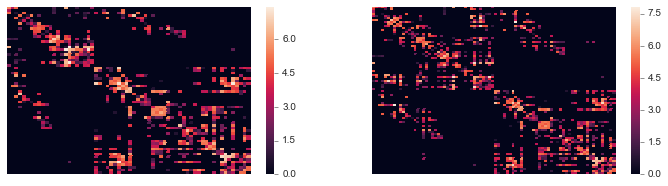

In [29]:
fig, ax = plt.subplots(ncols=2, figsize=(12,3)) 

sns.heatmap(s1_conn.weights[intact_idxs,:][:,intact_idxs],xticklabels='',yticklabels='',ax=ax[0])
sns.heatmap(s1_conn.weights,xticklabels='',yticklabels='',ax=ax[1]);

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Showing only the intact connections of course looks a bit lop-sided because it there is a complete right hemisphere and only around half of the left hemisphere. We will make use of this type of plot when we want to look at the 'downstream' effects of lesions in regions and connections (particularly functional connectivity) that are not themselves directly affected. 

Ok, now let's get on to the good stuff.

</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Define simulation functions</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Next we will define some helper functions for that simplify the process of running multiple simulations, and compactly summarizing their outputs. 

<h3><font size="4" face="arial" color="black">Main function</font></h3>

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

This is our main workhorse function. 

The first half should be fairly familiar to those who have had some seen simulations specified through the TVB command line interface alterady (which should be everyone as this is a relatively advanced tutorial). 

The key components of the model we are using are:

<br> <br>

- Conduction velocity: 3 m/s  
- Generic 2-D oscillator model for local dynamics (more on this below)  
- Linear coupling between regions (coupling gain will be our main parameter of interest)  
- Heun-Stochastic integration scheme  
- Temporal average monitor  

<br> <br>


The second half may be new to some: here we first put the simulation output into a [pandas dataframe](https://pandas.pydata.org/pandas-docs/stable/index.html), which is an extremely widely used tool for generic data manipulation, interrogation, and visualization. 

We then make use of some of the built-in statistical functionalities of dataframes to calculate summary metrics on the simulated outputs:  *global variance*, *average variance*, *variance of node variance*, *average pearson correlation*, *average node degree*. The function returns these metrics along with the simulated time series. 
</font></div></p>

In [30]:
g2do_params = dict(a=0.0,alpha=1.0,b=-12.3083,beta=0.,c=0.0,
                   d=0.07674,e=0.0,f=1.0,g=-1.205,gamma=1.0,tau=1.0)

def run_g2do_sim(conn=s1_conn,
                 sim_len=1000.,
                 G=0.3,CV=3.,                 # global parameters
                 g2do_params=g2do_params,        # local model parameters
                 dt=0.5,nsig=1E-5,               # integrator parameters
                 include_nodes='all',skip=250.): # summary metric calculation parameters
    
    conn.speed = CV
    conn.configure()
   
    mod = models.Generic2dOscillator(**g2do_params)
    
    cpl = coupling.Linear(a=G)
    
    solver = integrators.HeunStochastic(noise=noise.Additive(nsig=nsig),dt=dt)
    
    mons = (monitors.TemporalAverage(),)
    
    sim = simulator.Simulator(connectivity=conn,
                              model=mod,
                              integrator=solver,
                              coupling=cpl,
                              monitors=mons)
    sim.configure()
    
    (tavg_time,tavg_dat), = sim.run(simulation_length=sim_len)

    tavg = pd.DataFrame(np.squeeze(tavg_dat),index=tavg_time)
    tavg.columns = conn.region_labels
    tavg.columns.names = ['region']
    tavg.index.names = ['t']
            
    if include_nodes is 'all': include_nodes = np.arange(conn.number_of_regions)
            
    tvnv = tavg.loc[skip:].iloc[:,include_nodes].var().var()
    tmnv = tavg.loc[skip:].iloc[:,include_nodes].var().mean()
    tgv = tavg.loc[skip:].iloc[:,include_nodes].unstack().var()
    
    tpcmn = tavg.loc[skip:].iloc[:,include_nodes].corr().unstack().abs().mean()
    tpcstd = tavg.loc[skip:].iloc[:,include_nodes].corr().unstack().abs().std()
        
    cntthr = 0.5
    tndeg = (tavg.loc[skip:].iloc[:,include_nodes].corr().unstack().abs()>cntthr).sum()        
        
    SC = conn.weights[include_nodes,:][:,include_nodes]
    FC = tavg.loc[skip:].corr().abs().values[include_nodes,:][:,include_nodes]
    tpccorrSC = np.corrcoef(np.triu(SC,1).ravel(),np.triu(FC,1).ravel())[0,1]
        
    hasnans = tavg.unstack().isnull().sum() != 0
        
    return tavg,tvnv,tmnv,tgv,tpcmn,tpcstd,tndeg,tpccorrSC,hasnans

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
Quick test of this function: </font></div></p>


In [31]:
%%time
test_sim = run_g2do_sim()

Wall time: 1.86 s


In [32]:
len(test_sim)

9

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
The first element returned is the dataframe of simulated time series (temporal average monitor)
</font></div></p>

In [33]:
test_sim[0].iloc[:5,:5]

region,ctx-lh-lateralorbitofrontal,ctx-lh-parsorbitalis,ctx-lh-frontalpole,ctx-lh-medialorbitofrontal,ctx-lh-parstriangularis
t,,,,,
0.5,0.334594,2.532294,1.535465,1.684273,-0.217218
1.5,0.699130,1.484163,1.079628,1.610537,0.675914
2.5,1.286088,1.142614,0.764019,1.768938,1.056055
3.5,1.467789,1.155592,0.440320,1.345740,1.045381
4.5,1.267790,0.350090,-0.074199,0.914091,1.715032


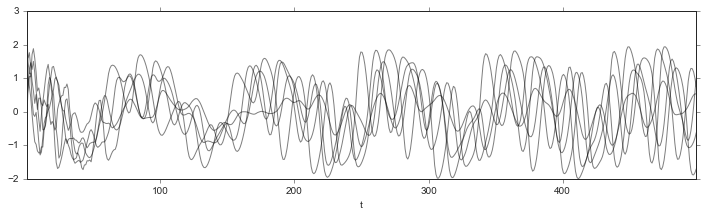

In [34]:
test_sim[0].loc[:500].iloc[:,:5].plot(legend=False, c='k', alpha=0.5,figsize=(12,3))

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

The rest of the elements are the various summary metrics

</font></div></p>


In [35]:
print('variance of node variances: %1.2f' %test_sim[1])
print('mean of node variances: %1.2f' %test_sim[2])
print('global varinace: %1.2f' %test_sim[3])
print('mean pearson correlation of node time series: %1.2f' %test_sim[4])
print('stdev pearson correlation of node time series: %1.2f' %test_sim[5])
print('node degree: %s' %test_sim[6])
print('correlation of pearson correlation FC with structural connectitivty: %1.2f' %test_sim[7])
print('contains NaNs:  %s' % test_sim[8])

variance of node variances: 3.79
mean of node variances: 1.95
global varinace: 1.95
mean pearson correlation of node time series: 0.40
stdev pearson correlation of node time series: 0.28
node degree: 2154
correlation of pearson correlation FC with structural connectitivty: 0.40
contains NaNs:  False


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Moving on: the central idea of a parameter space exploration is to set up a model with all but a small number of parameters fixed, and then to vary those parameters of interest systematically within some pre-specified range and summarize the outputs of the simulation runs for each parameter set with some summary metric. 


<br> <br>


When doing this one wants for the sake of simplicity to separate fixed and varying parameters, but ultimately these need to be put back together for each simulation run. The following function simplifies this process: it accepts a set of fixed parameters and a set of different values for the varied parameters, and returns a list of complete parameter sets for the `run_g2do_sim` function defined above

</font></div></p>

In [36]:
def gen_paramcombs(fixed_params,varied_params):
        
    allparams = []
    combs = list(itertools.product(*varied_params.values()))
    for c in combs:
        newparamset = deepcopy(fixed_params)
        for pname,pval in zip(varied_params.keys(),c):
            newparamset[pname] = pval
        allparams.append(newparamset)        
        
    return allparams

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 


So, suppose we have the following non-default fixed parameters for `run_g2do_sim`: 

</font></div></p>

In [37]:
fixed_params = dict(conn=s2_conn,sim_len=500.,skip=150,dt=0.1,nsig=1E-5,
                    g2do_params=g2do_params)

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

And we want to vary (as we will do below) global coupling and conduction velocity in the following ranges:
</font></div></p>

In [38]:
Gs = np.arange(0.01,0.6,0.06)
CVs = np.arange(0.1,30,3) 

In [39]:
Gs.shape

(10L,)

In [40]:
Gs

array([ 0.01,  0.07,  0.13,  0.19,  0.25,  0.31,  0.37,  0.43,  0.49,  0.55])

In [41]:
CVs.shape

(10L,)

In [42]:
CVs

array([  0.1,   3.1,   6.1,   9.1,  12.1,  15.1,  18.1,  21.1,  24.1,  27.1])

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
We can now do the following: </font></div></p>


In [43]:
varied_params = {'G': list(Gs), 'CV': list(CVs)}
fv_params = gen_paramcombs(fixed_params,varied_params)

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

And we now have a list of complete input arguments for `run_g2do_sim` for all (10 Gs x 10 CVs = 100 ) combinations
</font></div></p>

In [44]:
len(fv_params)

100

In [45]:
fv_params[0]

{'CV': 0.10000000000000001,
 'G': 0.01,
 'conn': Connectivity(bound=False, value=None),
 'dt': 0.1,
 'g2do_params': {'a': 0.0,
  'alpha': 1.0,
  'b': -12.3083,
  'beta': 0.0,
  'c': 0.0,
  'd': 0.07674,
  'e': 0.0,
  'f': 1.0,
  'g': -1.205,
  'gamma': 1.0,
  'tau': 1.0},
 'nsig': 1e-05,
 'sim_len': 500.0,
 'skip': 150}

In [46]:
fv_params[1]

{'CV': 0.10000000000000001,
 'G': 0.069999999999999993,
 'conn': Connectivity(bound=False, value=None),
 'dt': 0.1,
 'g2do_params': {'a': 0.0,
  'alpha': 1.0,
  'b': -12.3083,
  'beta': 0.0,
  'c': 0.0,
  'd': 0.07674,
  'e': 0.0,
  'f': 1.0,
  'g': -1.205,
  'gamma': 1.0,
  'tau': 1.0},
 'nsig': 1e-05,
 'sim_len': 500.0,
 'skip': 150}

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

..etc.

<br>
<br>

Ok, now we get to the heart of this tutorial: simulating the effects of brain lesions. 

</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Effects of lesions on brain dynamics 1: PSEs</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

The following cell runs a 10 x 10 PSE as specified above for all 5 subjects'intact and lesioned connectivities.
 
<br> <br>
 
It takes approximately 10-15 minutes to run on a standard laptop, depending on CPU specs etc. 


<br> <br>



***Important note:*** This set of simulations is *extremely* time-compressed and pared-down. In practice you should expect to be doing much longer simulation runs, particularly if you are interested in modelling fMRI data. For EEG/MEG data, you can potentially get a lot done more quickly; but in general you should still be using longer runs and shorter integration step sizes than those used here. Nevertheless, as we shall see, one can gain a lot of useful information about system dynamics and behaviour in different regions of parameter space with rapid exploratory runs of this kind. )

</font></div></p>

In [ ]:
%%time

pse_res = {}

for conn_name,conn in all_conns.items():
    
    if 'lhmca' in conn_name:
        include_nodes = intact_idxs
    else:
        include_nodes = np.arange(conn.number_of_regions)
    
    fixed_params = dict(conn=conn,
              sim_len=1000.,
              skip=250,#None,#500,#G=0.0039,
              dt=0.5,
              nsig=1E-1,
              g2do_params=g2do_params,
              include_nodes=include_nodes)# "all") # intact_idxs)#include_nodes)

    Gs = np.arange(0.01,0.6,0.06)
    CVs = np.arange(0.1,30,3)     
    varied_params = {'G': list(Gs), 'CV': list(CVs)}

    fv_params = gen_paramcombs(fixed_params,varied_params)

    psweep_res = [run_g2do_sim(**p) for p in fv_params]

    ss_res = {}
    for kv_it,(k,v) in enumerate(zip(fv_params,psweep_res)):        
        ss_res[kv_it] = {'G': k['G'], 'CV': k['CV'], 'tvnv': v[1], 'tmnv': v[2], 'tgv': v[3], 
                         'tpcmn': v[4], 'tpcstd': v[5], 'tndeg': v[6], 'tpccorrSC': v[7], 'hasnans': v[8]}
        
    ss_res = pd.DataFrame(ss_res).T
    ss_res.index.names = ['pset_num']
    pse_res[conn_name] = {'psweep_res': psweep_res,
                          'summary': ss_res}
    

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
We now have a dictionary for each of our 10 connectivities
</font></div></p>

In [70]:
len(pse_res)

10

In [71]:
sorted(pse_res.keys())

['s1',
 's1_lhmca',
 's2',
 's2_lhmca',
 's3',
 's3_lhmca',
 's4',
 's4_lhmca',
 's5',
 's5_lhmca']

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
Each of which contains the full parameter sweep outputs, and a summary table of the 7 summary metrics for every parameter combination:
</font></div></p>

In [72]:
len(pse_res['s1']['psweep_res'])

100

In [73]:
len(pse_res['s1']['psweep_res'][0])

9

In [74]:
pse_res['s1']['summary'].head()

,CV,G,hasnans,tgv,tmnv,tndeg,tpccorrSC,tpcmn,tpcstd,tvnv
pset_num,,,,,,,,,,
0,0.1,0.01,False,0.519452,0.519852,82,0.173568,0.0792351,0.114077,0.00200078
1,0.1,0.07,False,0.543905,0.54432,82,0.171912,0.0805832,0.114394,0.00244185
2,0.1,0.13,False,0.605103,0.605571,82,0.182811,0.0831502,0.114737,0.00509458
3,0.1,0.19,False,0.702445,0.703001,82,0.201301,0.0859253,0.114926,0.0125096
4,0.1,0.25,False,0.832844,0.833519,82,0.211812,0.0877725,0.115412,0.0270588


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

In the following we are mainly concerned with the summary table, which is primarily what one is interested in with PSEs (for larger parameter ranges and/or longer runs it isn't feasible to keep the simulation time series in memory. We can do that here because this is a fairly minimal example). 


<br> <br>


The following cell plots the correlation of pearson correlation functional connectivity matrices with structural connectivity matrices over the 2-dimensional parameter space of global coupling (G) vs. conduction velocity (CV). The first column is for the non-lesioned ('control') connectivity, the middle column is the lesioned connectivity, and the third column is the difference (control minus lesioned). Positive/negative values in these difference maps therefore show where the fit is increased/reduced after a lesion.


<br> <br>


Here we are essentially using structural connectivity as a simple and readily available surrogate for empirical functional connectivity (e.g. from resting state fMRI), which we often want to fit with our simulations. It would for example be straightforward to swap in empirical FC matrices and compute the same PSE heatmaps. Of course in order to properly model BOLD fMRI data (using the TVB BOLD monitor) would also involve considerably longer simulations than done here; which is beyond the scope of this tutorial. Irrespective of this, because BOLD FC is often very similar to anatomical connectivity anyway, comparisons with SC are extremely useful for parameter tuning and model exploration. More on this below. 

</font></div></p>

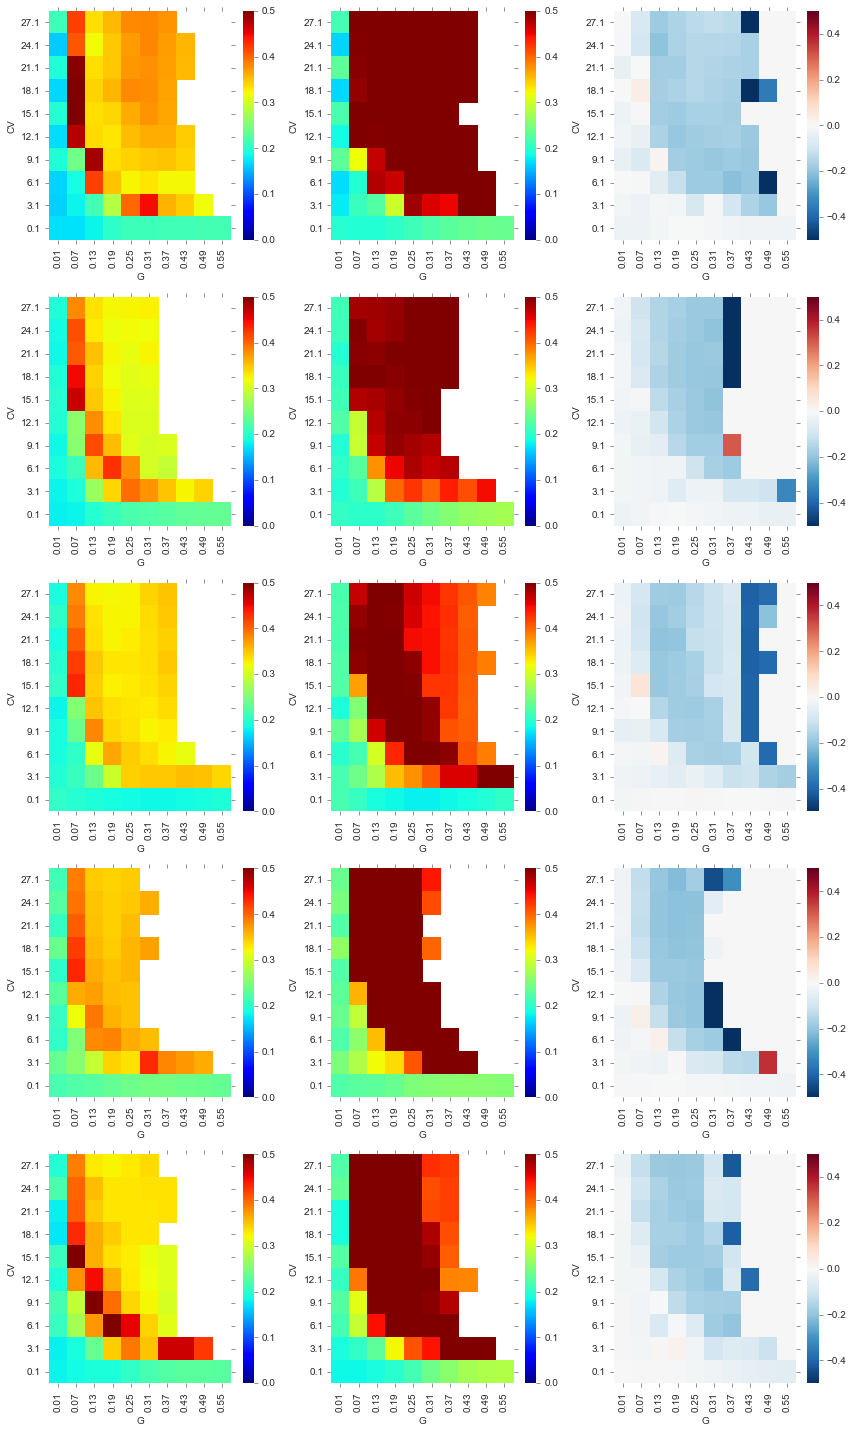

In [75]:
fig, ax = plt.subplots(ncols=3,nrows=5, figsize=(12,20))

for n_it,n in enumerate(['s1','s2','s3','s4','s5']):

    dat1 = pse_res[n]['summary'].set_index(['G', 'CV'])['tpccorrSC'].unstack().T.iloc[::-1,:].copy()
    dat1 = dat1.replace(np.nan, 0).replace(np.inf,0)
    dat1_nanmap = pse_res[n]['summary'].set_index(['G', 'CV'])['hasnans'].unstack().T.iloc[::-1,:]
    sns.heatmap(dat1,cmap='jet',ax=ax[n_it,0],vmin=0,vmax=0.5,mask=dat1_nanmap.values)

    dat2 = pse_res[n + '_lhmca']['summary'].set_index(['G', 'CV'])['tpccorrSC'].unstack().T.iloc[::-1,:].copy()
    dat2 = dat2.replace(np.nan, 0).replace(np.inf,0)    
    dat2_nanmap = pse_res[n+'_lhmca']['summary'].set_index(['G', 'CV'])['hasnans'].unstack().T.iloc[::-1,:]
    sns.heatmap(dat2,cmap='jet',ax=ax[n_it,1],vmin=0,vmax=0.5,mask=dat2_nanmap.values)

    dat3 = dat1-dat2
    sns.heatmap(dat3,cmap='RdBu_r',ax=ax[n_it,2],vmin=-0.5,vmax=0.5)#,cmap='RdBu_r')##,mask=dat_nanmap.values==False)
    
plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 
Now we will use the values in these PSE plots identify the 'best fit' values of `G` and `CV` for every subject's original and lesioned PSE runs. 

</font></div></p>


In [76]:
best_psets = {}
for n_it,name in enumerate(['s1','s2','s3','s4','s5']):

    res = pse_res[name]['summary'].copy()
    best_pset = res.sort_values(['tpccorrSC'], ascending=False)
    best_pset_num = best_pset.index[0]
    tmp = best_pset.iloc[0,:].copy()
    tmp['group'] = 'control'
    tmp['num'] = best_pset_num
    best_psets[name] = tmp
    
    name += '_lhmca'
    res = pse_res[name]['summary'].copy()
    best_pset = res.sort_values(['tpccorrSC'], ascending=False)
    best_pset_num = best_pset.index[0]
    tmp = best_pset.iloc[0,:].copy()
    tmp['group'] = 'patient'
    tmp['num'] = best_pset_num
    best_psets[name] = tmp
    
    

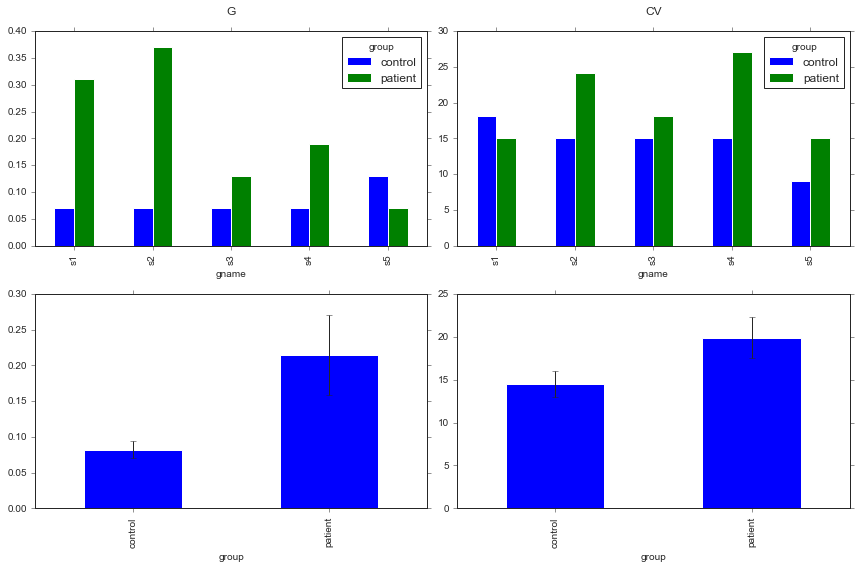

In [77]:
df = pd.DataFrame(best_psets).T.copy()
df['gname'] = [i.replace('_lhmca', '') for i in df.index]

dfG = df.set_index(['group', 'gname'])['G'].unstack().T
dfG = dfG.loc[['s1', 's2', 's3', 's4', 's5']]

dfCV = df.set_index(['group', 'gname'])['CV'].unstack().T
dfCV = dfCV.loc[['s1', 's2', 's3', 's4', 's5']]


fig, ax = plt.subplots(ncols=2,nrows=2,figsize=(12,8))

dfG.plot(kind='bar',ax=ax[0][0],title='G\n')
dfCV.plot(kind='bar', ax=ax[0][1], title='CV\n')

dfG.mean().plot(kind='bar',yerr=dfG.sem(),ax=ax[1][0]);
dfCV.mean().plot(kind='bar',yerr=dfCV.sem(),ax=ax[1][1]);

plt.tight_layout()


<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

The top row shows individual-subject comparisons in the optimal global coupling gain and conduction velocity parameters. The bottom row shows group-wise comparisons for these. 

<br> <br>

As we can see, there is a profound and mostly consistent shift towards higher values of G in the lesioned brains, in all but one case.  This is consistent with what we saw in the full PSE maps.

<br> <br>

In short, the model suggests that higher inter-regional coupling strengths are needed to maintain functional connectivity after the loss of network nodes and edges resulting from an MCAI stroke lesion. 

<br> <br>



We can also explore some of the other summary metrics calculated in the same way: 


<br> <br>


</font></div></p>

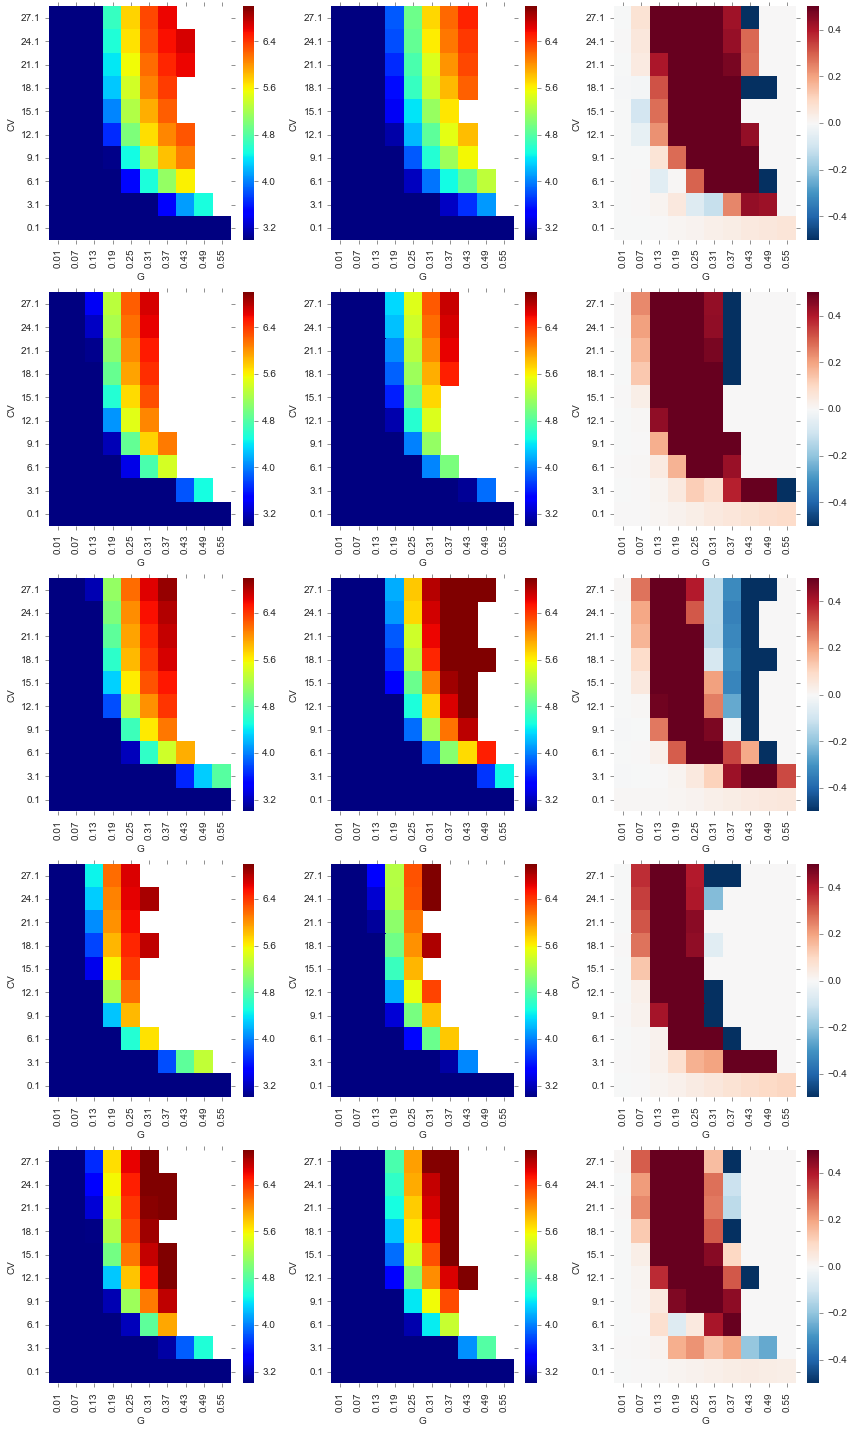

In [78]:
fig, ax = plt.subplots(ncols=3,nrows=5, figsize=(12,20))

for n_it,n in enumerate(['s1','s2','s3','s4','s5']):

    dat1 = pse_res[n]['summary'].set_index(['G', 'CV'])['tgv'].unstack().T.iloc[::-1,:].copy()
    dat1 = dat1.replace(np.nan, 0).replace(np.inf,0)
    dat1_nanmap = pse_res[n]['summary'].set_index(['G', 'CV'])['hasnans'].unstack().T.iloc[::-1,:]
    sns.heatmap(dat1,cmap='jet',ax=ax[n_it,0],vmin=3.,vmax=7.,mask=dat1_nanmap.values)

    dat2 = pse_res[n + '_lhmca']['summary'].set_index(['G', 'CV'])['tgv'].unstack().T.iloc[::-1,:].copy()
    dat2 = dat2.replace(np.nan, 0).replace(np.inf,0)    
    dat2_nanmap = pse_res[n+'_lhmca']['summary'].set_index(['G', 'CV'])['hasnans'].unstack().T.iloc[::-1,:]
    sns.heatmap(dat2,cmap='jet',ax=ax[n_it,1],vmin=3.,vmax=7.,mask=dat2_nanmap.values)

    dat3 = dat1-dat2
    sns.heatmap(dat3,cmap='RdBu_r',ax=ax[n_it,2],vmin=-0.5,vmax=0.5)#,cmap='RdBu_r')##,mask=dat_nanmap.values==False)
    
plt.tight_layout()

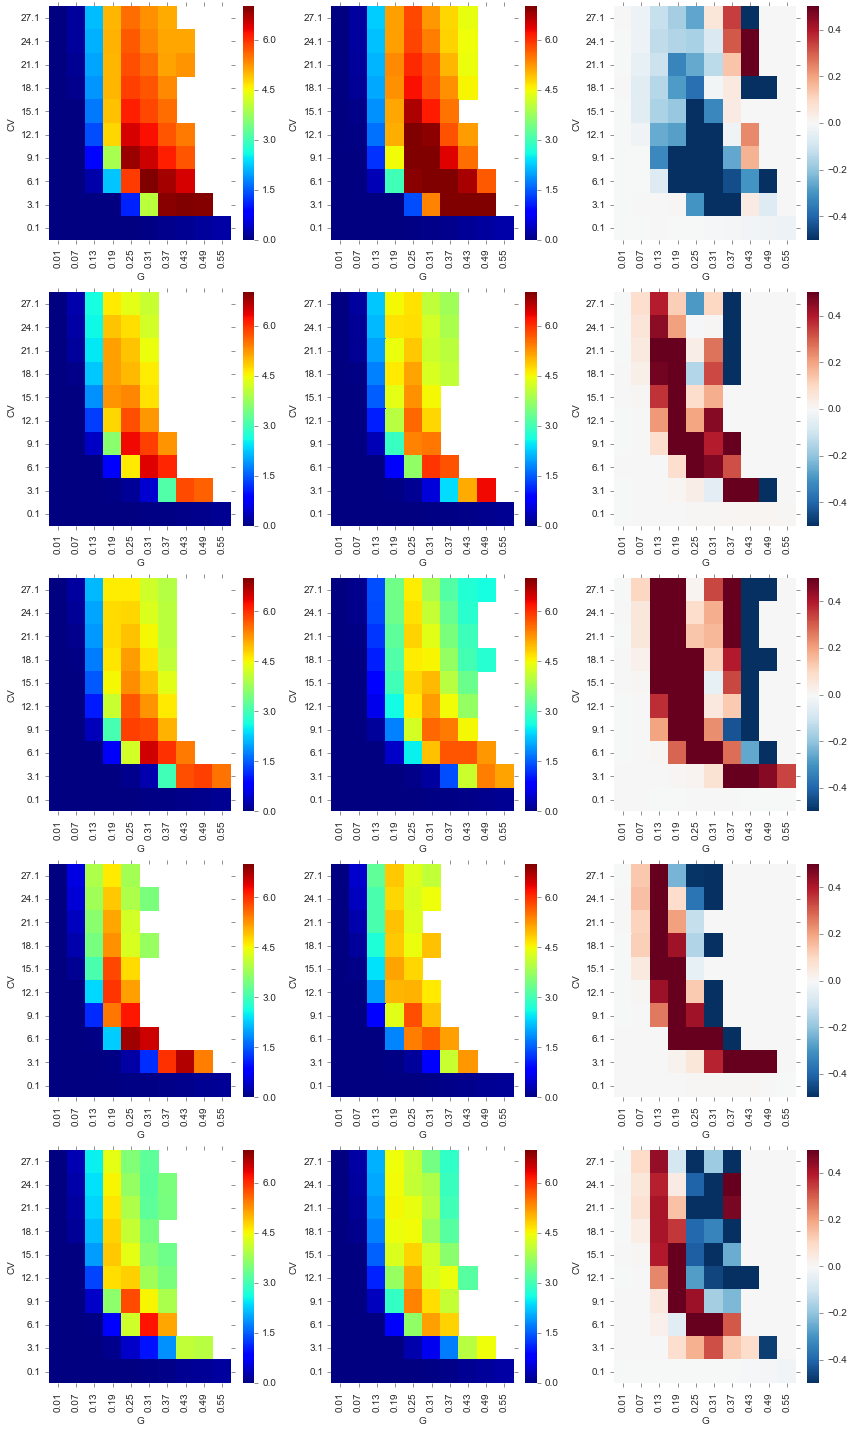

In [79]:
fig, ax = plt.subplots(ncols=3,nrows=5, figsize=(12,20))

for n_it,n in enumerate(['s1','s2','s3','s4','s5']):

    dat1 = pse_res[n]['summary'].set_index(['G', 'CV'])['tvnv'].unstack().T.iloc[::-1,:].copy()
    dat1 = dat1.replace(np.nan, 0).replace(np.inf,0)
    dat1_nanmap = pse_res[n]['summary'].set_index(['G', 'CV'])['hasnans'].unstack().T.iloc[::-1,:]
    sns.heatmap(dat1,cmap='jet',ax=ax[n_it,0],vmin=0.,vmax=7.,mask=dat1_nanmap.values)

    dat2 = pse_res[n + '_lhmca']['summary'].set_index(['G', 'CV'])['tvnv'].unstack().T.iloc[::-1,:].copy()
    dat2 = dat2.replace(np.nan, 0).replace(np.inf,0)    
    dat2_nanmap = pse_res[n+'_lhmca']['summary'].set_index(['G', 'CV'])['hasnans'].unstack().T.iloc[::-1,:]
    sns.heatmap(dat2,cmap='jet',ax=ax[n_it,1],vmin=0.,vmax=7.,mask=dat2_nanmap.values)

    dat3 = dat1-dat2
    sns.heatmap(dat3,cmap='RdBu_r',ax=ax[n_it,2],vmin=-0.5,vmax=0.5)#,cmap='RdBu_r')##,mask=dat_nanmap.values==False)
    
plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Here we see that another effect of the lesion is to increase the values of both global variance and variance of node variances over most of the parameter space.

</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Effects of lesions on brain dynamics 2: Functional connectivity</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Now we will focus in a bit more at on the simulation runs from best fitting parameter values. 

<br> <br>

Below we plot functional connectivity for subject 1, with and without MCAI lesion

</font></div></p>

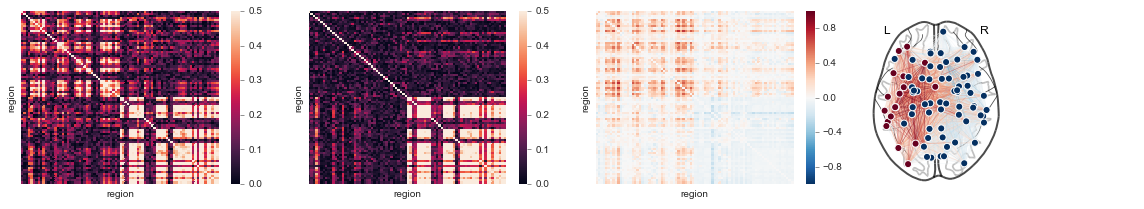

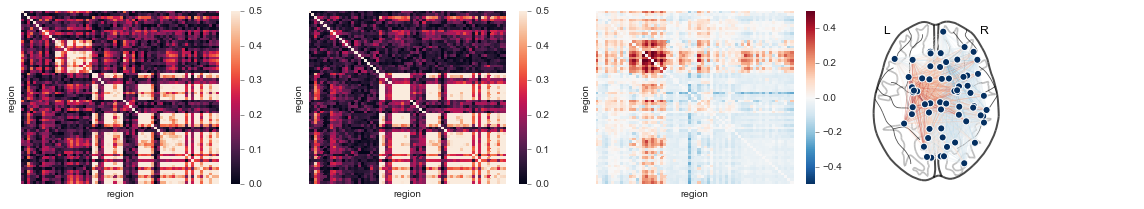

In [107]:
df1 = pse_res['s1']['psweep_res'][best_psets['s1']['num']][0].copy()
df2 = pse_res['s1_lhmca']['psweep_res'][best_psets['s1']['num']][0].copy()

df1c = df1.corr().abs()
df2c = df2.corr().abs()

dfcdiff = df1c- df2c



df1c_intact = df1c.iloc[intact_idxs,intact_idxs]
df2c_intact = df2c.iloc[intact_idxs,intact_idxs]
dfcdiff_intact = df1c_intact - df2c_intact

fig, ax = plt.subplots(ncols=4, figsize=(16,3))

sns.heatmap(df1c,ax=ax[0],xticklabels='',yticklabels='',vmin=0,vmax=0.5)
sns.heatmap(df2c,ax=ax[1],xticklabels='',yticklabels='',vmin=0,vmax=0.5)
sns.heatmap(dfcdiff,ax=ax[2],vmin=-1,vmax=1,cmap='RdBu_r',xticklabels='',yticklabels='')
 
_ = plot_connectome(dfcdiff.values,df_roi_xyz.values,edge_threshold=0.0,edge_vmin=-0.5,edge_vmax=0.5,
                      node_color=node_colors,alpha=0.01,edge_cmap='RdBu_r',
                      node_kwargs={'cmap': 'RdBu_r'},
                      edge_kwargs={'linewidth': 0.5, 'alpha': 0.5},
                      axes=ax[3], display_mode='z')
    
plt.tight_layout()

fig, ax = plt.subplots(ncols=4, figsize=(16,3))

sns.heatmap(df1c_intact,ax=ax[0],xticklabels='',yticklabels='',vmin=0,vmax=0.5)
sns.heatmap(df2c_intact,ax=ax[1],xticklabels='',yticklabels='',vmin=0,vmax=0.5)
sns.heatmap(dfcdiff_intact,ax=ax[2],vmin=-0.5,vmax=0.5,cmap='RdBu_r',xticklabels='',yticklabels='')

_ = plot_connectome(dfcdiff_intact.values,df_roi_xyz.values[intact_idxs],edge_threshold=0.0,edge_vmin=-0.5,edge_vmax=0.5,
                      node_color=node_colors[intact_idxs],alpha=0.01,edge_cmap='RdBu_r',
                      node_kwargs={'cmap': 'RdBu_r'},
                      edge_kwargs={'linewidth': 0.5, 'alpha': 0.5},
                      axes=ax[3], display_mode='z')


plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

Here again we are showing the full connectivity matrix in the first row, and the intact-only connectivity matrix in the second row. Remember we are really only interested in the second of these;  i.e. we aren't interested in any of the signals coming from the lesioned regions, or their correlations with other regions (we just kept them in the matrix and zeroed out all of their connections for purely practical reasons). But visual comparison is useful as well: in second column of the top row we can clearly see the effects of the lesions as dark bands of low functional connectivity with lesioned left hemisphere regions. The difference maps in the third column, and plotted on the brain in the fourth column, also show this clearly as stronger values (red colour) in the original vs. the lesioned connectivity.
 
<br> <br>
 
 
However the main comparisons of interest here are in the second row. This shows 'downstream' effects on functional connectivity between nodes unaffected by the lesions.

<br> <br>


These plots have two interesting features. Firstly, we can see that there is a strong and broad reduction in functional connectivity strengths of intact nodes in the ipsilesional hemisphere, both with other nodes in the same hemisphere (red values in the upper left quadrant in the third column), and with nodes in the contralesional hemisphere (blue values in the lower left and upper right quadrants in the third column). Second, within the contralesional hemisphere, we see a mild, but consistent  *increase* in functional connectivity; blue values in the matrix and brain plots in the third and fourth column.

<br> <br>

On these two, the reductions in FC clearly dominate, as we can see by comparing histograms of FC values:

</font></div></p>

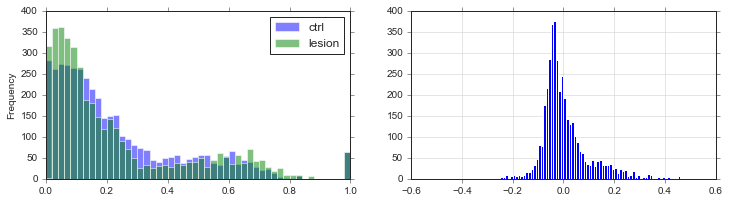

In [134]:
fig, ax = plt.subplots(ncols=2, figsize=(12,3))

df1 = pse_res['s1']['psweep_res'][best_psets['s1']['num']][0].copy()
df2 = pse_res['s1_lhmca']['psweep_res'][best_psets['s1']['num']][0].copy()
df1c = df1.corr().abs()
df2c = df2.corr().abs()
dfcdiff = df1c- df2c
df1c_intact = df1c.iloc[intact_idxs,intact_idxs]
df2c_intact = df2c.iloc[intact_idxs,intact_idxs]
dfcdiff_intact = df1c_intact - df2c_intact
    
df12cus = pd.concat({'ctrl': df1c_intact.unstack(),
                     'lesion': df2c_intact.unstack()},axis=1)
df12cus.iloc[:,:2].plot(kind='hist',bins=50,alpha=0.5,ax=ax[0])


dfcdiff_intact.unstack().hist(bins=np.arange(-0.5,0.5,0.01),ax=ax[1]);
ax[1].set_xlim([-0.6,0.6]);

In [124]:
(dfcdiff.unstack()<0).sum()

3110

In [123]:
(dfcdiff.unstack()>0).sum()

3532

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

These two figures show complementary information. The first shows the distributions of functional connectivity strengths between intact nodes with  (green) and without (blue) MCAI lesion. The distribution is clearly shifted towards lower values by the lesion. 

<br> <br>

The second shows the distribution of the differences; i.e. the changes to individual connections as a result of the lesion perturbation. Here we can se the separation between positive (i.e. connection strengths are reduced after applying the lesion) and negative (i.e. connection strengths are increased by the lesion). 


Here we can see that the majority of changes are positive (i.e. connections are reduced after applying the lesion). This is confirmed by the following calculation:

</font></div></p>

In [127]:
(dfcdiff.unstack()<0).sum()

3110

In [128]:
(dfcdiff.unstack()>0).sum()

3532

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 


This pattern is consistently observed (for the most part much more clearly in fact) in the rest of the subjects



</font></div></p>

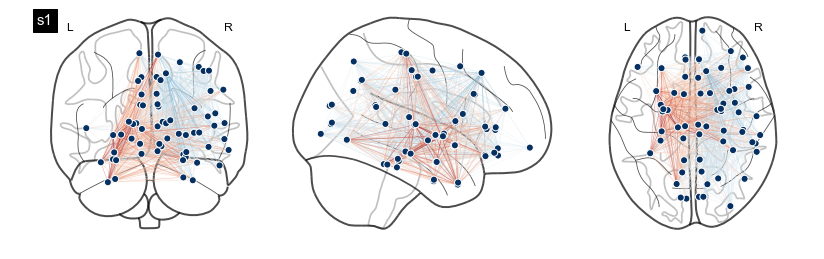

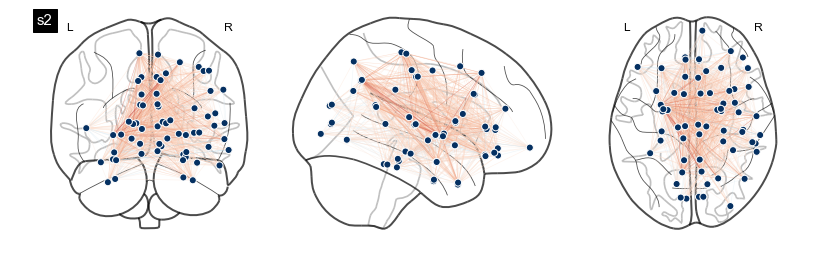

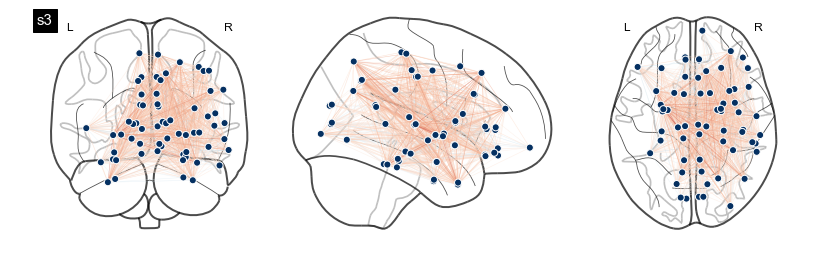

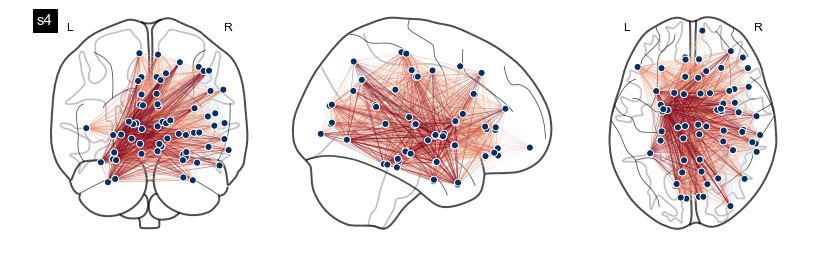

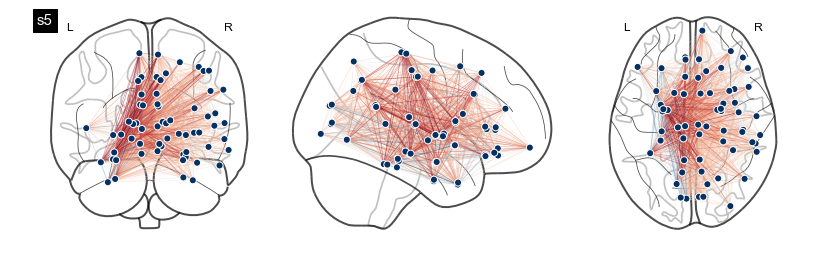

In [136]:
for n_it,n in enumerate(['s1','s2','s3','s4','s5']):

    fig, ax = plt.subplots(figsize=(14,4))

    df1 = pse_res[n]['psweep_res'][best_psets[n]['num']][0].copy()
    df2 = pse_res[n+'_lhmca']['psweep_res'][best_psets[n]['num']][0].copy()
    df1c = df1.corr().abs()
    df2c = df2.corr().abs()
    dfcdiff = df1c- df2c
    df1c_intact = df1c.iloc[intact_idxs,intact_idxs]
    df2c_intact = df2c.iloc[intact_idxs,intact_idxs]
    dfcdiff_intact = df1c_intact - df2c_intact
    _ = plot_connectome(dfcdiff_intact.values,df_roi_xyz.values[intact_idxs,:],edge_threshold=0.05,edge_vmin=-0.5,edge_vmax=0.5,
                      node_color=node_colors[intact_idxs],alpha=0.01,edge_cmap='RdBu_r',
                      node_kwargs={'cmap': 'RdBu_r'}, edge_kwargs={'linewidth': 0.5, 'alpha': 0.5},
                        axes=ax,title=n)

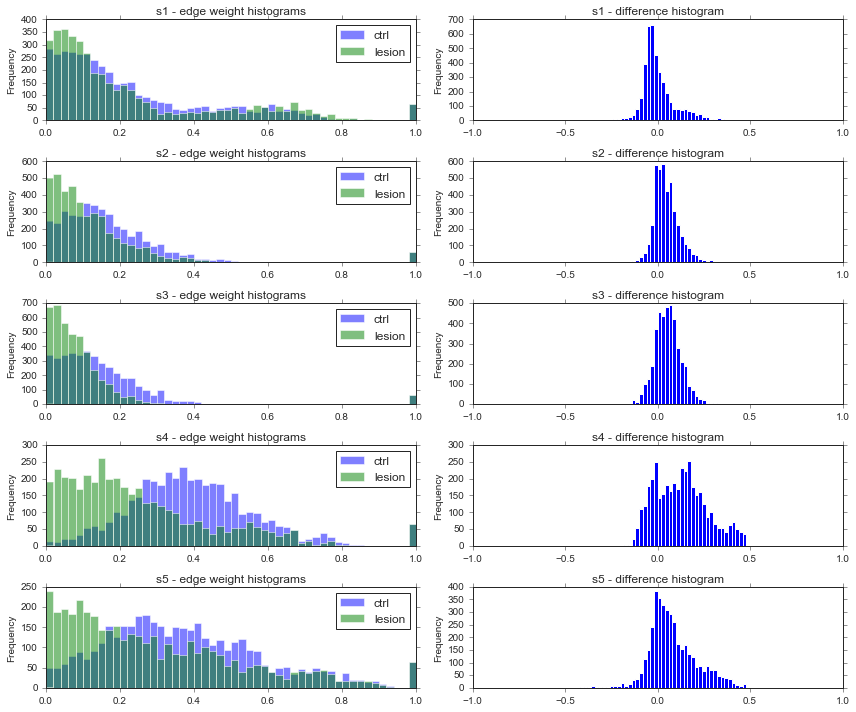

In [135]:
fig, ax = plt.subplots(ncols=2, nrows=5, figsize=(12,10))

for n_it,n in enumerate(['s1','s2','s3','s4','s5']):

    df1 = pse_res[n]['psweep_res'][best_psets[n]['num']][0].copy()
    df2 = pse_res[n+'_lhmca']['psweep_res'][best_psets[n]['num']][0].copy()
    df1c = df1.corr().abs()
    df2c = df2.corr().abs()
    dfcdiff = df1c- df2c
    df1c_intact = df1c.iloc[intact_idxs,intact_idxs]
    df2c_intact = df2c.iloc[intact_idxs,intact_idxs]
    dfcdiff_intact = df1c_intact - df2c_intact
    
    df12cus = pd.concat({'ctrl': df1c_intact.unstack(),
                    'lesion': df2c_intact.unstack()},axis=1)

    df12cus.iloc[:,:2].plot(kind='hist',bins=50,alpha=0.5,ax=ax[n_it,0],title='%s - edge weight histograms' %n)
    
    dfcdiff_intact.unstack().plot(kind='hist', bins=np.arange(-0.5,0.5,0.02),ax=ax[n_it,1],title='%s - difference histogram' %n);
    ax[n_it,1].set_xlim([-1.,1.]);
    
plt.tight_layout()

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

All of the above brain plots and histograms show reduced functional connectivity following MCAI lesion. 


They do however also serve to highlight another key point to bear in mind when doing personalized brain network modelling of this kind, namely the substantial amount of individual variability in response to the same MCAI lesion damage. For example, two subjects show some contralesional increases in functional connectivity after the lesion; but the other three do not. Likewise, the extent of separation between the 'control' and 'lesion' distributions shown above varies considerably between subjects. 

These differences are necessarily due only to individual differences in anatomical connectivity. 

</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">Conclusions</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman"> 

In this tutorial we have taken at one approach to modelling the effects of brain damage resulting from MCAI stroke using TVB. 

<br> <br>

The focus has primarily been on the process of setting up and running simulations with TVB; and we have made extensive use of interactive computing to explore, visualize, and better understand both the inputs to and outputs from our simulations. 

<br> <br>



Whole brain modelling of - particularly of real, individual patients' brains (as opposed to idealized cases such as targeted damage of topologically important nodes), is still a nascent area of research. There is much work to be done and much we do not know yet. Questions you may be interested in exploring in your future work TVB could include:

<br> <br>

- PSEs using other parameters, and other local models (e.g. Wilson-Cowan, Jansen-Rit, SJ3D)  
- Describing with more precision the differential contributions of grey and white matter damage  
- Other data features, such as power spectra for M/EEG power spectra or graph-theoretic network peroperties  
- Full BOLD fMRI simulations  




</font></div></p>

<h1><font size="6" face="arial" color="#609BC4">References</font></h1>
***

<p><div style="text-align: justify"><font size="4.5" face="time roman">

<blockquote> 

Falcon, M. I., Jirsa, V., & Solodkin, A. (2016). <b> A new neuroinformatics approach to personalized medicine in neurology: The Virtual Brain. </b> Current opinion in neurology, 29(4), 429. <br />  


Falcon, M. I., Riley, J. D., Jirsa, V., McIntosh, A. R., Chen, E. E., & Solodkin, A. (2016). <b> Functional mechanisms of recovery after chronic stroke: modeling with the Virtual Brain. </b> Eneuro, 3(2), ENEURO-0158.<br />  


Falcon, M. I., Riley, J. D., Jirsa, V., McIntosh, A. R., Shereen, A. D., Chen, E. E., & Solodkin, A. (2015). <b> The virtual brain: modeling biological correlates of recovery after chronic stroke. </b> Frontiers in neurology, 6, 228.    <br />    


Alstott, J., Breakspear, M., Hagmann, P., Cammoun, L., & Sporns, O. (2009). <b> Modeling the impact of lesions in the human brain. </b> PLoS computational biology, 5(6),  e1000408.<br />  


Honey, C. J., & Sporns, O. (2008). <b> Dynamical consequences of lesions in cortical networks. </b> Human brain mapping, 29(7), 802-809.<br />  


Ghosh, A., Rho, Y., McIntosh, A. R., Kötter, R., & Jirsa, V. K. (2008). <b> Noise during rest enables the exploration of the brain's dynamic repertoire. </b> PLoS computational biology, 4(10), e1000196.<br />  


Knock, S. A., McIntosh, A. R., Sporns, O., Kötter, R., Hagmann, P., & Jirsa, V. K. (2009). <b> The effects of physiologically plausible connectivity structure on local and global dynamics in large scale brain models. </b> Journal of neuroscience methods, 183(1), 86-94.<br />  


</font></div></p>